In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv("/home/karera/Desktop/SEMISTER11/big data/Churndata(1).csv")

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df["TotalCharges"].isnull().sum()


np.int64(11)

<Axes: xlabel='MonthlyCharges'>

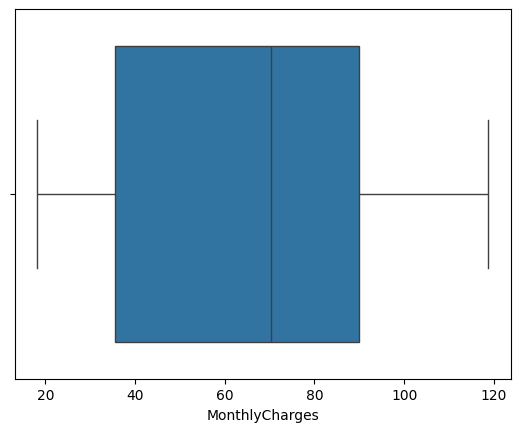

In [39]:
import seaborn as sns
sns.boxplot(x=df["MonthlyCharges"])


In [5]:
df["TotalCharges"].fillna(
    df["MonthlyCharges"] * df["tenure"],
    inplace=True
)


/tmp/ipykernel_6569/2188506239.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(


In [6]:
df[["MonthlyCharges", "TotalCharges"]].describe()


,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2279.734304
std,30.090047,2266.794470
min,18.250000,0.000000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


In [7]:
categorical_cols = df.select_dtypes(include="object").columns.drop(["customerID", "Churn"])
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns


In [8]:
df["TenureGroup"] = pd.cut(
    df["tenure"],
    bins=[0, 12, 24, 48, 72],
    labels=["0-1yr", "1-2yr", "2-4yr", "4-6yr"]
)


In [9]:
internet_plans = pd.DataFrame({
    "InternetService": ["DSL", "Fiber optic"],
    "Speed": [25, 100],
    "DataAllowance": [500, 2000]
})

df = df.merge(internet_plans, on="InternetService", how="left")


In [10]:
df[["Speed", "DataAllowance"]] = df[["Speed", "DataAllowance"]].fillna(0)


In [11]:
df.drop(columns=["customerID"], inplace=True)


In [12]:
selector = VarianceThreshold(threshold=0.01)


In [13]:
X = df.drop("Churn", axis=1)
y = df["Churn"].map({"No": 0, "Yes": 1})


In [14]:
X_encoded = pd.get_dummies(X, drop_first=True)


In [15]:
X_encoded.isnull().sum().sort_values(ascending=False).head(20)


SeniorCitizen                           0
tenure                                  0
MonthlyCharges                          0
TotalCharges                            0
Speed                                   0
DataAllowance                           0
gender_Male                             0
Partner_Yes                             0
Dependents_Yes                          0
PhoneService_Yes                        0
MultipleLines_No phone service          0
MultipleLines_Yes                       0
InternetService_Fiber optic             0
InternetService_No                      0
OnlineSecurity_No internet service      0
OnlineSecurity_Yes                      0
OnlineBackup_No internet service        0
OnlineBackup_Yes                        0
DeviceProtection_No internet service    0
DeviceProtection_Yes                    0
dtype: int64

In [16]:
df.loc[df["TotalCharges"].isna(), ["tenure", "MonthlyCharges", "TotalCharges"]]


,tenure,MonthlyCharges,TotalCharges


In [17]:
df.loc[df["tenure"] == 0, "TotalCharges"] = 0


In [18]:
df.loc[df["TotalCharges"].isna()]


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureGroup,Speed,DataAllowance


In [19]:
X = df.drop("Churn", axis=1)
y = df["Churn"].map({"No": 0, "Yes": 1})

X_encoded = pd.get_dummies(X, drop_first=True)


In [20]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)


In [22]:
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [23]:
df.columns.tolist()


['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'TenureGroup',
 'Speed',
 'DataAllowance']

In [24]:
X_encoded.columns.tolist()


['SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'Speed',
 'DataAllowance',
 'gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'TenureGroup_1-2yr',
 'TenureGroup_2-4yr',
 'TenureGroup_4-6yr']

In [25]:
raw_features = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "tenure",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "MonthlyCharges",
    "Speed",
    "DataAllowance",
    "TenureGroup"
]


In [26]:
len(raw_features)


21

In [27]:
X = df[raw_features]
y = df["Churn"].map({"No": 0, "Yes": 1})


In [28]:
categorical_features = X.select_dtypes(include="object").columns.tolist()
numerical_features = X.select_dtypes(exclude="object").columns.tolist()


In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [30]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])


In [31]:
# Raw user-provided features (minimal)
raw_features = [
    "gender", "SeniorCitizen", "Partner", "Dependents", "tenure",
    "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
    "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod",
    "MonthlyCharges", "Speed", "DataAllowance", "TenureGroup"
]

# Feature matrix and target
X = df[raw_features]
y = df["Churn"].map({"No": 0, "Yes": 1})


In [32]:
# Explicitly select string columns (categorical)
categorical_features = X.select_dtypes(include=['object', 'string']).columns.tolist()

# Remaining columns are numerical
numerical_features = X.select_dtypes(exclude=['object', 'string']).columns.tolist()

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)


Categorical Features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical Features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Speed', 'DataAllowance', 'TenureGroup']


In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Numeric transformer
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [35]:
# ---------------------------
# 0️⃣ Import libraries
# ---------------------------
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

# ---------------------------
# 1️⃣ Define raw features and target
# ---------------------------
raw_features = [
    "gender", "SeniorCitizen", "Partner", "Dependents", "tenure",
    "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
    "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod",
    "MonthlyCharges", "Speed", "DataAllowance", "TenureGroup"
]

X = df[raw_features].copy()
y = df["Churn"].map({"No": 0, "Yes": 1})

# ---------------------------
# 2️⃣ Ensure correct dtypes
# ---------------------------

# Numeric features
numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "Speed", "DataAllowance"]
X[numeric_features] = X[numeric_features].apply(pd.to_numeric, errors="coerce")

# Categorical features
categorical_features = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod", "TenureGroup"
]
X[categorical_features] = X[categorical_features].astype(str)

# ---------------------------
# 3️⃣ Split train/test (no leakage)
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------
# 4️⃣ Build preprocessing pipelines
# ---------------------------

# Numeric imputer pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Categorical imputer + one-hot encoder pipeline
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Combine pipelines
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# ---------------------------
# 5️⃣ Build SMOTE + Logistic Regression pipeline
# ---------------------------
model = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

# ---------------------------
# 6️⃣ Train the model
# ---------------------------
model.fit(X_train, y_train)
print("Model trained successfully!")

# ---------------------------
# 7️⃣ Evaluate
# ---------------------------
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# ---------------------------
# 8️⃣ Save the trained model
# ---------------------------
joblib.dump(model, "telco_churn_model.pkl")
print("Model saved as telco_churn_model.pkl")


Model trained successfully!
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.79      0.74      0.75      1409

ROC-AUC: 0.838195251750239
Model saved as telco_churn_model.pkl


/home/karera/Desktop/betty/betty/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
import joblib

# Load trained model
model = joblib.load("telco_churn_model.pkl")
print("Model loaded successfully!")


Model loaded successfully!


In [38]:
import pandas as pd

def predict_churn(user_input: dict):
    """
    Predicts churn probability for a single customer.
    
    Parameters:
    -----------
    user_input : dict
        Dictionary containing the 20 raw features:
        gender, SeniorCitizen, Partner, Dependents, tenure, 
        PhoneService, MultipleLines, InternetService, OnlineSecurity,
        OnlineBackup, DeviceProtection, TechSupport, StreamingTV, 
        StreamingMovies, Contract, PaperlessBilling, PaymentMethod,
        MonthlyCharges, Speed, DataAllowance, TenureGroup

    Returns:
    --------
    float : Probability of churn (0-1)
    int   : Predicted class (0 = No churn, 1 = Churn)
    """
    # Convert input dict to dataframe
    input_df = pd.DataFrame([user_input])

    # Ensure proper dtypes
    categorical_cols = [
        "gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
        "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
        "TechSupport", "StreamingTV", "StreamingMovies",
        "Contract", "PaperlessBilling", "PaymentMethod", "TenureGroup"
    ]
    
    numeric_cols = ["SeniorCitizen", "tenure", "MonthlyCharges", "Speed", "DataAllowance"]
    
    input_df[categorical_cols] = input_df[categorical_cols].astype(str)
    input_df[numeric_cols] = input_df[numeric_cols].apply(pd.to_numeric, errors="coerce")
    
    # Predict probability
    churn_prob = model.predict_proba(input_df)[:, 1][0]
    churn_class = model.predict(input_df)[0]
    
    return churn_prob, churn_class
